# Credit Risk Model

This notebook presents the implementation of a credit risk model using three classification algorithms: Logistic Regression, Random Forest, and XGBoost. The model evaluates the accuracy and AUC score for each algorithm, and it also generates confusion matrices and ROC curves to assess the performance of each model.

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder

## Benchmark

First, we will set our benchmark. We will build a logistic regression model without doing any transformations. No scaling, no fitting, no label encoding, just the raw data as it is.

In [3]:
class Benchmark:
    def __init__(self, data):
        # Initialize class
        self.data = data
        self.predictor_columns = ['Credit_History_Age_Months', 'Num_Bank_Accounts', 'Num_Credit_Card',
                                  'Num_of_Loan', 'Outstanding_Debt', 'Delay_from_due_date', 'Num_Credit_Inquiries']
        self.response_column = 'Score_Category'
        self.model = None

        # Split data into train and test
        self.data_train, self.data_test = train_test_split(self.data, test_size=0.2, random_state=42)

    def train_logistic_regression(self):
        # Select predictors and target
        X_train = self.data_train[self.predictor_columns]
        y_train = self.data_train[self.response_column]
        X_test = self.data_test[self.predictor_columns]
        y_test = self.data_test[self.response_column]

        # Train logistic regression model
        self.model = LogisticRegression(max_iter=1000, multi_class='ovr')
        self.model.fit(X_train, y_train)

        # Predict
        y_pred = self.model.predict(X_test)
        y_prob = self.model.predict_proba(X_test)

        # Accuracy
        accuracy = accuracy_score(y_test, y_pred)

        # AUC score
        lb = LabelBinarizer()
        y_test_bin = lb.fit_transform(y_test)
        auc_score = roc_auc_score(y_test_bin, y_prob, multi_class='ovr')

        # Confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)

        return accuracy, auc_score, conf_matrix, X_test, y_test

    def plot_roc_curve(self, X_test, y_test):
        # ROC curve
        y_prob = self.model.predict_proba(X_test)
        lb = LabelBinarizer()
        y_test_bin = lb.fit_transform(y_test)

        plt.figure(figsize=(10, 8))
        n_classes = y_test_bin.shape[1]

        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

    def plot_confusion_matrix(self, conf_matrix):
        # Confusion matrix
        plt.figure(figsize=(7, 5))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.show()

    def evaluate(self):
        # Train and evaluate model
        accuracy, auc_score, conf_matrix, X_test, y_test = self.train_logistic_regression()
        print("Benchmark Logistic Regression")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"AUC Score: {auc_score:.4f}")
        self.plot_roc_curve(X_test, y_test)
        self.plot_confusion_matrix(conf_matrix)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Benchmark Logistic Regression
Accuracy: 0.5901
AUC Score: 0.7525


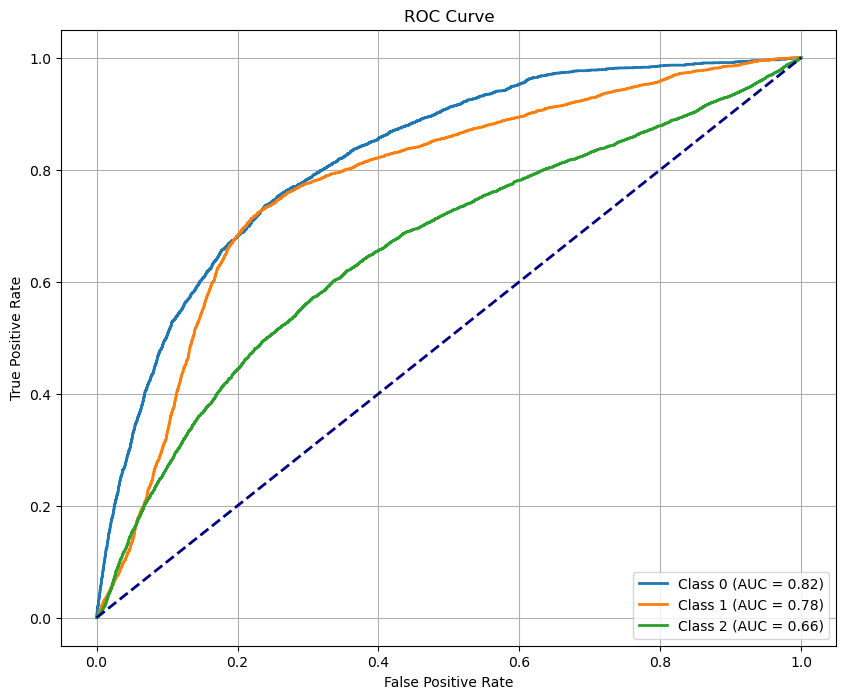

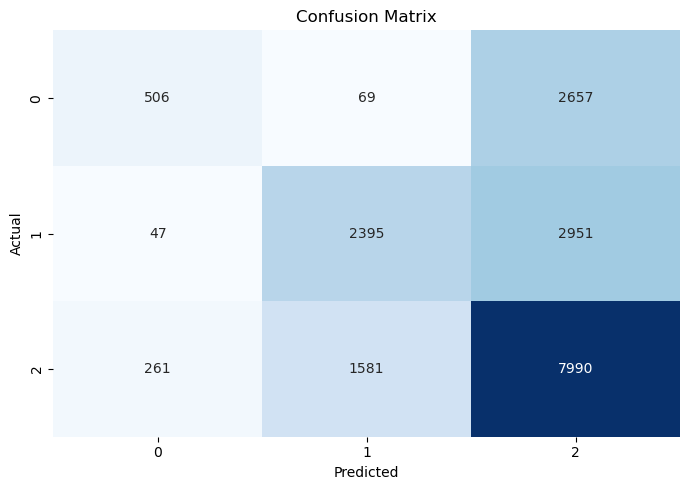

In [5]:
# Create an instance for Benchmark
data = pd.read_csv('train_cleaned.csv')
model = Benchmark(data)
model.evaluate()

## Credit Risk Model

Now lets evaluate the same model but using labelencoder, and normalizing the predictor variables. To compare it with our benchmark.

In [50]:
class CreditRiskModel:
    def __init__(self, data):
        self.data = data
        self.predictor_columns = ['Credit_History_Age_Months', 'Num_Bank_Accounts', 'Num_Credit_Card',
                                  'Num_of_Loan', 'Outstanding_Debt', 'Delay_from_due_date', 'Num_Credit_Inquiries']
        self.response_column = 'Score_Category'
        self.model = None
        self.scaler = StandardScaler()
        self.data_train, self.data_test = train_test_split(self.data, test_size=0.2, random_state=42)

        # Initialize LabelEncoder for converting categorical target labels to numerical values
        self.label_encoder = LabelEncoder()
    
    def preprocess_data(self, data):
        X = data[self.predictor_columns]
        y = data[self.response_column]

        # Convert labels to numeric values
        y_encoded = self.label_encoder.fit_transform(y)

        # Normalize the predictor variables
        X_scaled = self.scaler.fit_transform(X)

        return X_scaled, y_encoded

    def train_classifier(self, model_type: str):
        X_train, y_train = self.preprocess_data(self.data_train)
        X_test, y_test = self.preprocess_data(self.data_test)

        # Train according to the specified model
        if model_type == 'svm':
            self.model = SVC(kernel='linear', probability=True, random_state=42)
        elif model_type == 'random_forest':
            self.model = RandomForestClassifier(n_estimators=100, random_state=42)
        elif model_type == 'xgboost':
            self.model = XGBClassifier(n_estimators=100, random_state=42)
        else:
            raise ValueError("Model type not supported. Choose 'svm', 'random_forest' or 'xgboost'.")

        # Fit the model
        self.model.fit(X_train, y_train)

        # Predictions and probabilities
        y_pred = self.model.predict(X_test)
        y_prob = self.model.predict_proba(X_test)  # This gives probabilities for each class

        # Calculate metrics
        validation_accuracy = accuracy_score(y_test, y_pred)

        # Calculate the AUC score for each class using one-vs-rest (ovr) strategy
        lb = LabelBinarizer()
        y_test_bin = lb.fit_transform(y_test)
        auc_score = roc_auc_score(y_test_bin, y_prob, multi_class='ovr')

        # Confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)

        return validation_accuracy, auc_score, conf_matrix, X_test, y_test

    def plot_roc_curve(self, X_test, y_test):
        # Plot the AUC-ROC curve for each class
        y_prob = self.model.predict_proba(X_test)
        
        lb = LabelBinarizer()
        y_test_bin = lb.fit_transform(y_test)
        
        # Set up the plot
        plt.figure(figsize=(10, 8))
        n_classes = y_test_bin.shape[1]
        
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')
        
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()

    def plot_confusion_matrix(self, conf_matrix):
        # Plot the confusion matrix
        plt.figure(figsize=(7, 5))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Poor', 'Standard', 'Good'], yticklabels=['Poor', 'Standard', 'Good'])
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    def evaluate_model(self, model_type: str):
        validation_accuracy, auc_score, conf_matrix, X_test, y_test = self.train_classifier(model_type=model_type)
        print(f"Model: {model_type}")
        print(f"Accuracy: {validation_accuracy:.4f}")
        print(f"AUC Score: {auc_score:.4f}")
        
        self.plot_roc_curve(X_test, y_test)
        self.plot_confusion_matrix(conf_matrix)


In [13]:
class CreditRiskModel:
    def __init__(self, data):
        self.data = data
        self.predictor_columns = ['Credit_History_Age_Months', 'Num_Bank_Accounts', 'Num_Credit_Card',
                                  'Num_of_Loan', 'Outstanding_Debt', 'Delay_from_due_date', 'Num_Credit_Inquiries']
        self.response_column = 'Score_Category'
        self.model = None
        self.scaler = StandardScaler()
        self.data_train, self.data_test = train_test_split(self.data, test_size=0.2, random_state=42)

        # Initialize LabelEncoder for converting categorical target labels to numerical values
        self.label_encoder = LabelEncoder()
    
    def preprocess_data(self, data):
        X = data[self.predictor_columns]
        y = data[self.response_column]

        # Convert labels to numeric values
        y_encoded = self.label_encoder.fit_transform(y)

        # Normalize the predictor variables
        X_scaled = self.scaler.fit_transform(X)

        return X_scaled, y_encoded

    def train_classifier(self, model_type: str):
        X_train, y_train = self.preprocess_data(self.data_train)
        X_test, y_test = self.preprocess_data(self.data_test)

        # Train according to the specified model
        if model_type == 'mlp':
            self.model = MLPClassifier(hidden_layer_sizes=(200, 100), activation='relu', max_iter=1000, random_state=42)
        elif model_type == 'random_forest':
            from sklearn.ensemble import RandomForestClassifier
            self.model = RandomForestClassifier(n_estimators=100, random_state=42)
        elif model_type == 'xgboost':
            from xgboost import XGBClassifier
            self.model = XGBClassifier(n_estimators=100, random_state=42)
        else:
            raise ValueError("Model type not supported. Choose 'mlp', 'random_forest', or 'xgboost'.")

        # Fit the model
        self.model.fit(X_train, y_train)

        # Predictions and probabilities
        y_pred = self.model.predict(X_test)
        y_prob = self.model.predict_proba(X_test)  # This gives probabilities for each class

        # Calculate metrics
        validation_accuracy = accuracy_score(y_test, y_pred)

        # Calculate the AUC score for each class using one-vs-rest (ovr) strategy
        lb = LabelBinarizer()
        y_test_bin = lb.fit_transform(y_test)
        auc_score = roc_auc_score(y_test_bin, y_prob, multi_class='ovr')

        # Confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)

        return validation_accuracy, auc_score, conf_matrix, X_test, y_test

    def plot_roc_curve(self, X_test, y_test):
        # Plot the AUC-ROC curve for each class
        y_prob = self.model.predict_proba(X_test)
        
        lb = LabelBinarizer()
        y_test_bin = lb.fit_transform(y_test)
        
        # Set up the plot
        plt.figure(figsize=(10, 8))
        n_classes = y_test_bin.shape[1]
        
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')
        
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()

    def plot_confusion_matrix(self, conf_matrix):
        # Plot the confusion matrix
        plt.figure(figsize=(7, 5))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Poor', 'Standard', 'Good'], yticklabels=['Poor', 'Standard', 'Good'])
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    def evaluate_model(self, model_type: str):
        validation_accuracy, auc_score, conf_matrix, X_test, y_test = self.train_classifier(model_type=model_type)
        print(f"Model: {model_type}")
        print(f"Accuracy: {validation_accuracy:.4f}")
        print(f"AUC Score: {auc_score:.4f}")
        
        self.plot_roc_curve(X_test, y_test)
        self.plot_confusion_matrix(conf_matrix)


### Load data and evaluate

In [15]:
# Load the data
data = pd.read_csv('train_cleaned.csv')

data

,Age,Occupation,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Num_Credit_Inquiries,...,Outstanding_Debt,Credit_Utilization_Ratio,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Credit_History_Age_Months,Score_Category
0,23,Scientist,19114.12,3,4,3,4,3,7.000000,4.0,...,809.98,26.822620,No,49.574949,80.415295,High_spent_Small_value_payments,312.494089,2,265,Good
1,23,Scientist,19114.12,3,4,3,4,5,4.000000,4.0,...,809.98,31.377862,No,49.574949,199.458074,Low_spent_Small_value_payments,223.451310,2,268,Good
2,23,Scientist,19114.12,3,4,3,4,6,31.202764,4.0,...,809.98,24.797347,No,49.574949,41.420153,High_spent_Medium_value_payments,341.489231,2,269,Good
3,23,Scientist,19114.12,3,4,3,4,8,4.000000,4.0,...,809.98,27.262259,No,49.574949,62.430172,Low_spent_Small_value_payments,340.479212,2,270,Good
4,23,Scientist,19114.12,3,4,3,4,3,8.000000,4.0,...,809.98,22.537593,No,49.574949,178.344067,Low_spent_Small_value_payments,244.565317,2,271,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92280,25,Mechanic,39628.99,4,6,7,2,23,7.000000,3.0,...,502.38,34.663572,No,35.104023,60.971333,High_spent_Large_value_payments,479.866228,0,378,Poor
92281,25,Mechanic,39628.99,4,6,7,2,18,7.000000,3.0,...,502.38,40.565631,No,35.104023,54.185950,High_spent_Medium_value_payments,496.651610,0,379,Poor
92282,25,Mechanic,39628.99,4,6,24,2,27,6.000000,3.0,...,502.38,41.255522,No,35.104023,24.028477,High_spent_Large_value_payments,516.809083,0,380,Poor
92283,25,Mechanic,39628.99,4,6,7,2,20,31.202764,3.0,...,502.38,33.638208,No,35.104023,251.672582,Low_spent_Large_value_payments,319.164979,1,381,Standard


Model: mlp
Accuracy: 0.7005
AUC Score: 0.8454


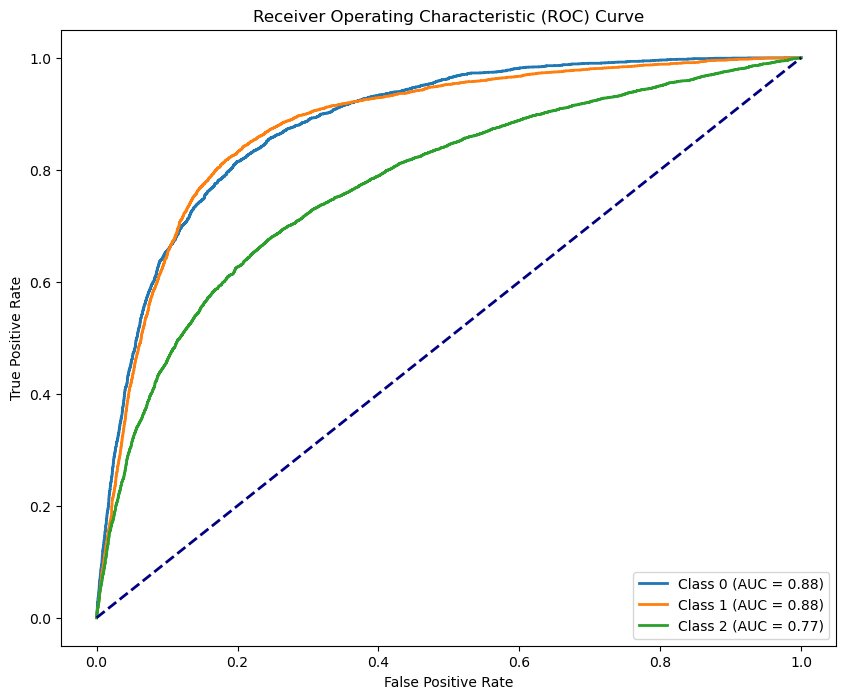

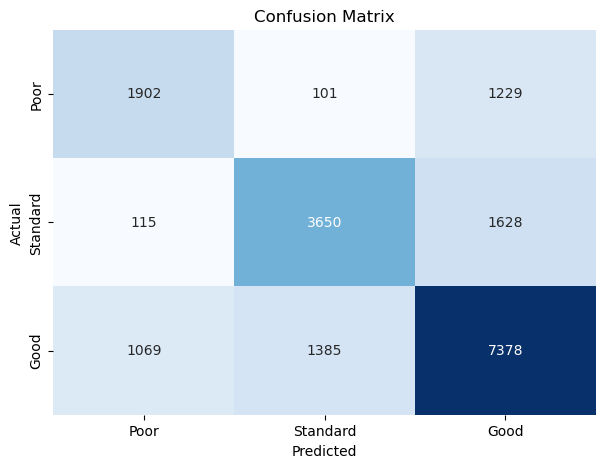

Model: random_forest
Accuracy: 0.7842
AUC Score: 0.9087


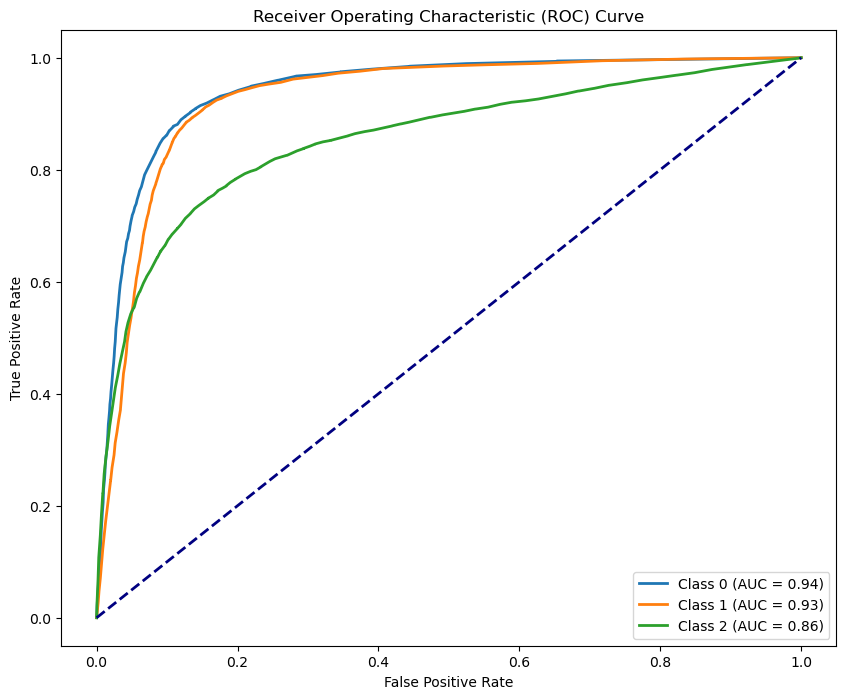

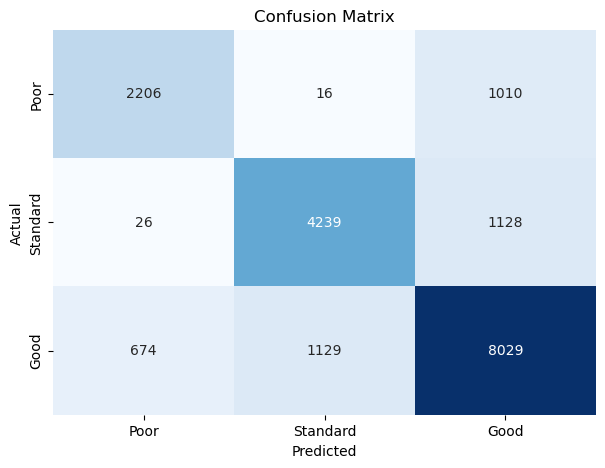

Model: xgboost
Accuracy: 0.6741
AUC Score: 0.8296


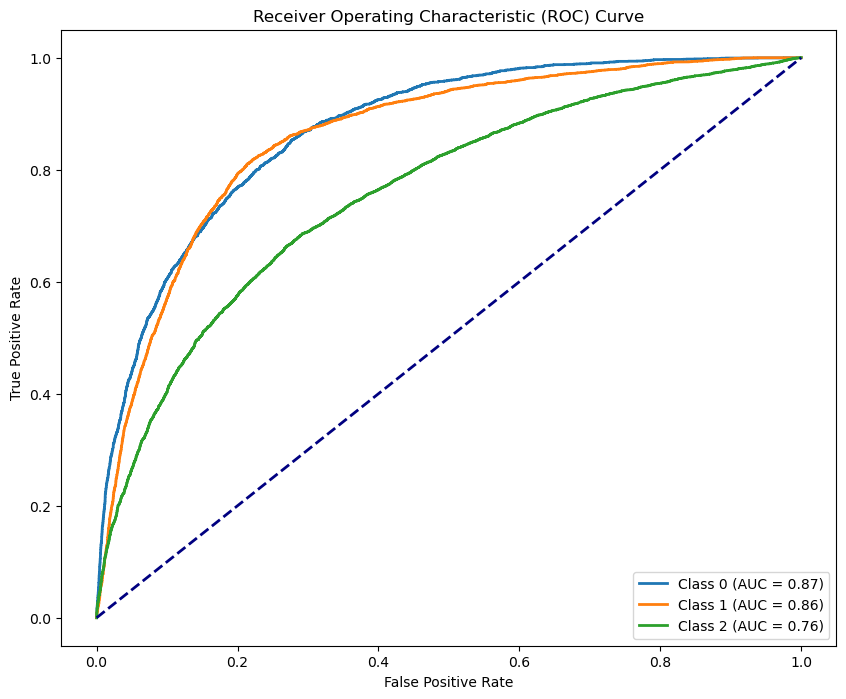

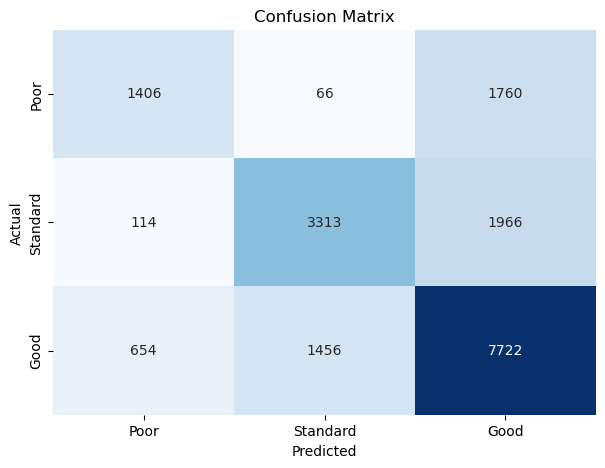

In [17]:
# Create an instance of CreditRiskModel
model = CreditRiskModel(data)

# Evaluate each model
model.evaluate_model('mlp')
model.evaluate_model('random_forest')
model.evaluate_model('xgboost')